# <center style='color:blue'>Generative Adversarial Network (`GAN`) using PyTorch - Example with `MNIST` dataset</center>

# 1. Import required libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


# 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `MNIST` dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
mnist_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 19028220.89it/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 339315668.97it/s]


Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2848065.27it/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 13725164.82it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



In [5]:
print('Length of the MNIST (training) dataset:', len(mnist_dataset))

Length of the MNIST (training) dataset: 60000


In [6]:
print('Shape of the MNIST (training) dataset:', mnist_dataset.data.shape)

Shape of the MNIST (training) dataset: torch.Size([60000, 28, 28])


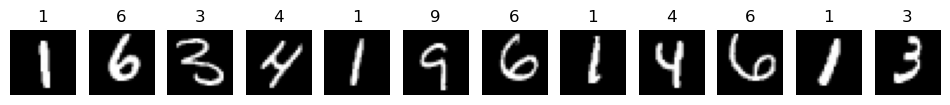

In [7]:
# show 12 randomly selected samples from the MNIST (training) dataset

fig, axis = plt.subplots(nrows=1, ncols=12, figsize=(12, 3))

for ax, _ in zip(axis.ravel(), range(12)):
    inx = np.random.randint(len(mnist_dataset))
    ax.imshow(mnist_dataset.data[inx], cmap='gray')
    ax.set_title(int(mnist_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

# 4. Define dataloader

In [8]:
data_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)

In [9]:
print('Length of the dataloader (training):', len(data_loader))

Length of the dataloader (training): 468


# 5. Create `DISCRIMINATOR` architecture

In [10]:
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()
        
        self.discriminator = nn.Sequential()
        self.discriminator.add_module('linr1', nn.Linear(in_features=28*28, out_features=1024))
        self.discriminator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop1', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr2', nn.Linear(in_features=1024, out_features=512))
        self.discriminator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop2', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr3', nn.Linear(in_features=512, out_features=256))
        self.discriminator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('drop3', nn.Dropout(p=0.3))
        self.discriminator.add_module('linr4', nn.Linear(in_features=256, out_features=1))
        self.discriminator.add_module('sgmd4', nn.Sigmoid())
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.discriminator(x)
        return x

# 6. Visualize `DISCRIMINATOR` architecture

In [11]:
summary(DISCRIMINATOR(), input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DISCRIMINATOR                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 1024]               803,840
│    └─LeakyReLU: 2-2                    [128, 1024]               --
│    └─Dropout: 2-3                      [128, 1024]               --
│    └─Linear: 2-4                       [128, 512]                524,800
│    └─LeakyReLU: 2-5                    [128, 512]                --
│    └─Dropout: 2-6                      [128, 512]                --
│    └─Linear: 2-7                       [128, 256]                131,328
│    └─LeakyReLU: 2-8                    [128, 256]                --
│    └─Dropout: 2-9                      [128, 256]                --
│    └─Linear: 2-10                      [128, 1]                  257
│    └─Sigmoid: 2-11                     [128, 1]                  --

# 7. Create `GENERATOR` architecture

In [12]:
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()
        
        self.generator = nn.Sequential()
        self.generator.add_module('linr1', nn.Linear(in_features=100, out_features=256))
        self.generator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr2', nn.Linear(in_features=256, out_features=512))
        self.generator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr3', nn.Linear(in_features=512, out_features=1024))
        self.generator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.generator.add_module('linr4', nn.Linear(in_features=1024, out_features=28*28))
        self.generator.add_module('tanh4', nn.Tanh())
        
    def forward(self, x):
        x = self.generator(x)
        return x

# 8. Visualize `GENERATOR` architecture

In [13]:
summary(GENERATOR(), input_size=(128, 100))

Layer (type:depth-idx)                   Output Shape              Param #
GENERATOR                                [128, 784]                --
├─Sequential: 1-1                        [128, 784]                --
│    └─Linear: 2-1                       [128, 256]                25,856
│    └─LeakyReLU: 2-2                    [128, 256]                --
│    └─Linear: 2-3                       [128, 512]                131,584
│    └─LeakyReLU: 2-4                    [128, 512]                --
│    └─Linear: 2-5                       [128, 1024]               525,312
│    └─LeakyReLU: 2-6                    [128, 1024]               --
│    └─Linear: 2-7                       [128, 784]                803,600
│    └─Tanh: 2-8                         [128, 784]                --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 190.25
Input size (MB): 0.05
Forward/backward pass size (MB): 2.64
Params size (MB): 5.95
Estimated Total Siz

# 9. Custom function to generate `random noise` 

In [14]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 100)
    return noise

# 10. Custom function to train the `discriminator`

In [15]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer):
    
    preds_real = model(real_samples)
    error_real = criterion(preds_real, torch.ones(len(real_samples), 1).to(device))
    
    preds_fake = model(fake_samples)
    error_fake = criterion(preds_fake, torch.zeros(len(fake_samples), 1).to(device))
    
    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

# 11. Custom function to train the `generator`

In [16]:
def generator_training_batch(fake_samples, model, criterion, optimizer):
    
    preds = model(fake_samples)
    error = criterion(preds, torch.ones(len(fake_samples), 1).to(device)) # to fool the discriminator
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    return error

# 12. Set up models, criterion (`loss function`) and optimizers

In [17]:
discriminator = DISCRIMINATOR().to(device)
generator = GENERATOR().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

# 13. Train `GAN`

In [18]:
torch.manual_seed(111)
torch.cuda.manual_seed(111)
torch.cuda.manual_seed_all(111)
np.random.seed(111)

n_epochs = 200
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []
    
    for data, _ in tqdm(data_loader):
        
        real_data = data.to(device)
        fake_data = generator(random_noise(batch_size=128).to(device)).to(device)
        fake_data = fake_data.detach()
        
        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator,
                                                          criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())
        
        fake_data = generator(random_noise(batch_size=128).to(device)).to(device)
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion,
                                          optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())
        
    discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
    generator_per_epoch_loss = np.array(generator_losses).mean()
    
    discriminator_loss.append(discriminator_per_epoch_loss)
    generator_loss.append(generator_per_epoch_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Discriminator loss: {discriminator_per_epoch_loss:.4f} |   ', end='')
        print(f'Generator loss: {generator_per_epoch_loss:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.55it/s]


Epoch: 10/200	| Discriminator loss: 0.6437 |   Generator loss: 2.4242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.29it/s]


Epoch: 20/200	| Discriminator loss: 0.7632 |   Generator loss: 1.9739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.52it/s]


Epoch: 30/200	| Discriminator loss: 0.9523 |   Generator loss: 1.5156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.01it/s]


Epoch: 40/200	| Discriminator loss: 1.0113 |   Generator loss: 1.3895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.10it/s]


Epoch: 50/200	| Discriminator loss: 1.0881 |   Generator loss: 1.2204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 70.83it/s]


Epoch: 60/200	| Discriminator loss: 1.1375 |   Generator loss: 1.1370


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.26it/s]


Epoch: 70/200	| Discriminator loss: 1.1748 |   Generator loss: 1.0668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.14it/s]


Epoch: 80/200	| Discriminator loss: 1.1999 |   Generator loss: 1.0222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.55it/s]


Epoch: 90/200	| Discriminator loss: 1.2106 |   Generator loss: 0.9906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.45it/s]


Epoch: 100/200	| Discriminator loss: 1.2278 |   Generator loss: 0.9739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.09it/s]


Epoch: 110/200	| Discriminator loss: 1.2509 |   Generator loss: 0.9464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 70.97it/s]


Epoch: 120/200	| Discriminator loss: 1.2440 |   Generator loss: 0.9443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.28it/s]


Epoch: 130/200	| Discriminator loss: 1.2524 |   Generator loss: 0.9387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.34it/s]


Epoch: 140/200	| Discriminator loss: 1.2589 |   Generator loss: 0.9127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.32it/s]


Epoch: 150/200	| Discriminator loss: 1.2703 |   Generator loss: 0.8955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.14it/s]


Epoch: 160/200	| Discriminator loss: 1.2712 |   Generator loss: 0.9121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.17it/s]


Epoch: 170/200	| Discriminator loss: 1.2696 |   Generator loss: 0.9012


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.31it/s]


Epoch: 180/200	| Discriminator loss: 1.2803 |   Generator loss: 0.8811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.32it/s]


Epoch: 190/200	| Discriminator loss: 1.2791 |   Generator loss: 0.8818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.32it/s]

Epoch: 200/200	| Discriminator loss: 1.2715 |   Generator loss: 0.8959


# 14. Plot losses

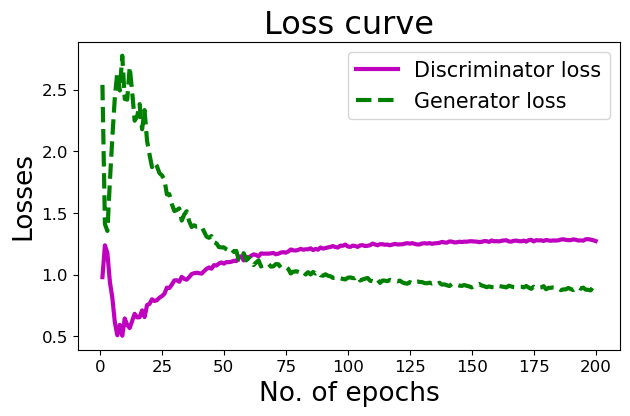

In [19]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(7, 4))
plt.plot(N, discriminator_loss, 'm-', linewidth=3, label='Discriminator loss')
plt.plot(N, generator_loss, 'g--', linewidth=3, label='Generator loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15);

# 15. Generate images from noise vectors 

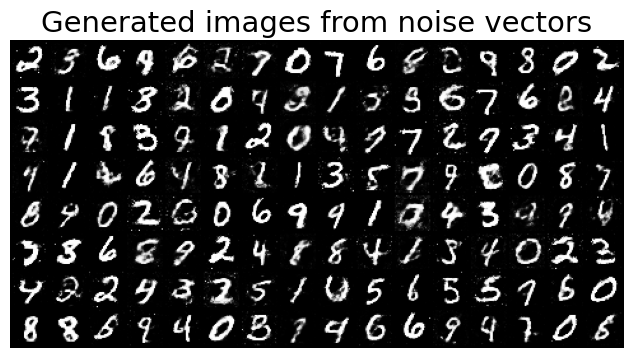

In [20]:
generator.eval()
n = torch.randn(128, 100)
random_samples = generator.cpu()(n).view(128, 1, 28, 28)
grid = make_grid(random_samples, nrow=16, normalize=True)
plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated images from noise vectors', fontsize=21);